_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Name: FILL IN YOUR NAMES HERE

# Coding Lab 6



In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)
sns.set_style('whitegrid')
%matplotlib inline

## Task: Implement entropy estimators




### General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$ s and $0$ s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


### Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


## MLE

$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$

In [53]:
def m_log(x):
    return np.log2(x, where=np.abs(x)>=1e-6, out=np.full_like(x, -1e6))

In [54]:
def entropy_mle(phat):
    '''Maximum likelihood or plug-in estimator of discrete entropy
    
    Parameter
    ---------
    
    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram
    
    Return
    ------
    H: float
        Entropy estimate
    '''
    # insert your code here (1 pt)

    H = -np.sum(phat* m_log(phat))

    
    return H


## Miller-Maddow corrected

$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$ 

$ \hat{d} = \#[\hat{p}(x)>0]$ 



In [55]:
def entropy_mm(phat, n):
    '''Miller-Maddow corrected estimator of discrete entropy
    
    Parameters
    ----------
    
    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram
        
    n:  int
        Number of samples
    

    Return
    ------
    
    H: float
        Entropy estimate
    '''

    # insert your code here (1 pt)
    dhat = len(phat[phat>0])

    H = -np.sum(phat* m_log(phat)) + (dhat-1)/(2*n)

    
    return H


## Jack-knife corrected

$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$ 

$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$

In [56]:
def entropy_jk(x, edges):
    '''Jack-knife corrected estimator of discrete entropy
    
    Parameters
    ----------
    x: np.array, shape=(n_samples, )
        Samples
        
    edges: np.array, shape=(n_bins, )
        Histogram bin edges
    
    
    Return
    ------
    
    H: float
        Entropy estimate
    '''

    # insert your code here (2 pt)
    N = len(x)

    # Defininig N_new as the minimum of N and 1000
    N_new = min(N, 1000) 

    y, _ = np.histogram(x, bins=edges)
    yhat = y/N

    Hml = entropy_mle(yhat) # First part of jack-knife entropy
    
    Hml_dot = 0

    # loop over each observation
    for i in range(N_new):
        # Deleting one observation
        x_sub = np.delete(x, i)
        y_sub, _ = np.histogram(x_sub, bins=edges) # histogram for sub-observations
        y_subhat = y_sub/len(x_sub)

        Hml_dot = Hml_dot +  entropy_mle(y_subhat)
    
    Hml_dot = Hml_dot/N_new # Expected value of H_ml_dot

    # Net Jack-knife entropy

    H = N*Hml - (N-1)*Hml_dot
    
    return H

## Coverage-adjusted

$C = 1 - \frac{\# f_{i}=1}{N}$

$\hat{P}_{C}= \hat{P}\cdot C$ 

$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$



In [57]:
def entropy_cae(phat, n):
    '''coverage-adjusted estimator of discrete entropy
    
    Parameters
    ----------
    
    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram
        
    n: int
        Number of samples.
    
    
    Return
    ------
    
    H: float
        Entropy estimate
    '''

    # insert your code here (1 pt)

    # fi==1 => frequencies that never repeated, i.e., only occurred once
    unique_val, counts = np.unique(phat, return_counts=True)
    fi1=len(counts[counts==1])

    C = 1- fi1/n

    phatc = phat*C

    # numerator and denominator
    numerator = phatc*m_log(phatc)
    denominator = 1 - (1-phatc)**n

    frac = numerator/(denominator + 1e-6) # It devides the term individually corresponding to the element i

    H = -np.sum(frac)
    
    return H

# JVHW

In [58]:
import sys
sys.path.append("../JVHW_Entropy_Estimators-master/Python")
sys.path.append("../JVHW_Entropy_Estimators-master/Matlab")

from est_entro import est_entro_JVHW

def entropy_jvhw(x):
    '''JVHW estimator of discrete entropy.
        
    Parameter
    ---------
    x: np.array, shape=(n_samples, )
        Samples
        
    Return
    ------
    H: float
        Entropy estimate
    '''

    # insert your code here (1 pt)

        
    H = est_entro_JVHW(x) # calculate the entropy using the JVHW estimator

    
    return H

# Optional: Unseen or Best Upper Bounds estimator

In [59]:
# insert your code here 

# ------------------------------------------
# Port Unseen or Best Upper Bounds estimator
# from MatLab to Python. (3 bonus pts)
# ------------------------------------------


### Uniform distribution

In [60]:
D = 10
N = 2**D

p = 1/N * np.ones(N)   # true distribution

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (2 pt)

True Entropy = 10.0
Entropy with 100 Samples = 6.523856189774724
Entropy with 10000 Samples = 9.922464753925762


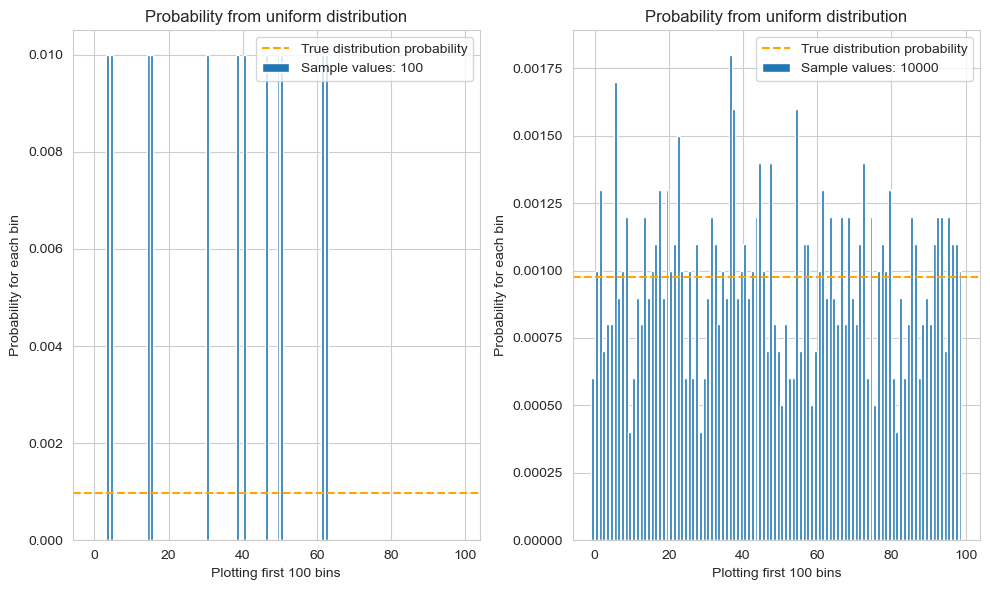

In [61]:
# insert your code here 

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------
edges = np.arange(-0.5, N, 1)
x1 = np.random.uniform(0,N,100)
count_val1, edges1= np.histogram(x1, bins = edges) # Will count how many times a number is repeated in the array
p1 = count_val1/100 # Deviding by N will give the frequency, i.e., the probability of a number repeating

H_100 = - np.sum(p1 * m_log(p1))

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------

x2 = np.random.uniform(0,N,10000).astype(int) # Converting to int basically binning it
count_val2, edges2= np.histogram(x2, bins = edges) # Will count how many times a number is repeated in the array
p2 = count_val2/10000 # Deviding by N will give the frequency, i.e., the probability of a number repeating

H_10000 = - np.sum(p2 * m_log(p2))

print(f"True Entropy = {H}")
print(f"Entropy with 100 Samples = {H_100}")
print(f"Entropy with 10000 Samples = {H_10000}")

# ------------------------------------
# Plot the true distribution and 
# the sampled distributions. (0.5 pts)
# ------------------------------------

fig, axis = plt.subplots(1,2,figsize=(10,6))

edge_val = [edges1,edges2]
p_val = [p1,p2]
sample_val = [100, 10000]
for i in range(2):
    ax = axis[i]
    ax.bar(edge_val[i][:-1][0:100], p_val[i][0:100], label=f'Sample values: {sample_val[i]}')
    ax.set_xlabel("Plotting first 100 bins")
    ax.set_ylabel("Probability for each bin")
    ax.axhline(p[0], label="True distribution probability",linestyle="--", color='Orange')
    ax.set_title("Probability from uniform distribution")
    ax.legend()
fig.tight_layout()


True Entropy = 10.0
Entropy with 100 Samples = 6.563856189774724
Entropy with 10000 Samples = 9.928621023462993


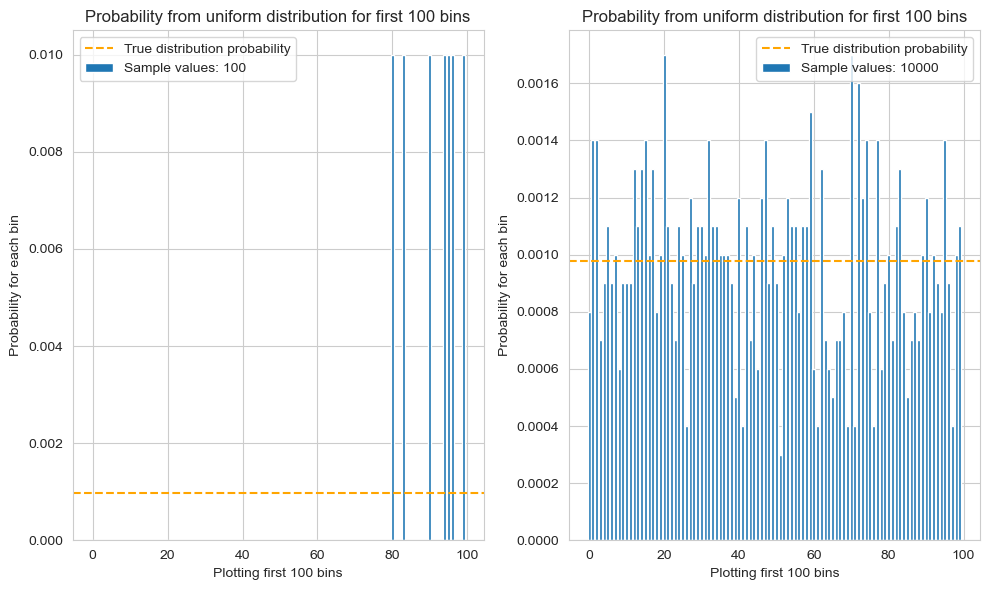

In [62]:
# insert your code here 

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------

S = 100
x1 = np.random.choice(N, size=int(S)) # sample S values from 0 to N-1
p1 = np.bincount(x1, minlength=N) / S # estimate the distribution from the sample

H_100 = - np.sum(p1 * m_log(p1))

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------

S = 10000
x2 = np.random.choice(N, size=int(S)) # sample S values from 0 to N-1
p2 = np.bincount(x2, minlength=N) / S # estimate the distribution from the sample

H_10000 = - np.sum(p2 * m_log(p2))

print(f"True Entropy = {H}")
print(f"Entropy with 100 Samples = {H_100}")
print(f"Entropy with 10000 Samples = {H_10000}")

# ------------------------------------
# Plot the true distribution and 
# the sampled distributions. (0.5 pts)
# ------------------------------------

fig, axis = plt.subplots(1,2,figsize=(10,6))

p_val = [p1,p2]
sample_val = [100, 10000]
for i in range(2):
    ax = axis[i]
    ax.bar(range(sample_val[i])[0:100], p_val[i][0:100], label=f'Sample values: {sample_val[i]}')
    ax.set_xlabel("Plotting first 100 bins")
    ax.set_ylabel("Probability for each bin")
    ax.axhline(p[0], label="True distribution probability",linestyle="--", color='Orange')
    ax.set_title("Probability from uniform distribution for first 100 bins")
    ax.legend()
fig.tight_layout()



Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [63]:
sample_sizes = np.round(np.logspace(1,5,num=10))
n_runs = 30

edges = np.arange(-0.5, N, 1)

h_mle  = np.zeros((len(sample_sizes), n_runs))
h_mm   = np.zeros((len(sample_sizes), n_runs))
h_jk   = np.zeros((len(sample_sizes), n_runs))
h_cae  = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):
        
        # ------------------------------------
        # Sample from the uniform distribution
        # with different sample size (0.5 pts)
        # ------------------------------------  
         
        # insert your code here  

        x = np.random.uniform(0, N, size=int(S)).astype(int) # sample S values from a uniform distribution over 0 to N-1
        y, _ = np.histogram(x, bins=edges) # calculate the histogram of the sample
        phat = y / S # estimate the distribution from the histogram


        h_mle[i,j]  = entropy_mle(phat)
        h_mm[i,j]   = entropy_mm(phat, S)
        h_cae[i,j]  = entropy_cae(phat, S)
        h_jk[i,j]   = entropy_jk(x, edges)
        h_jvhw[i,j] = entropy_jvhw(x)

Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

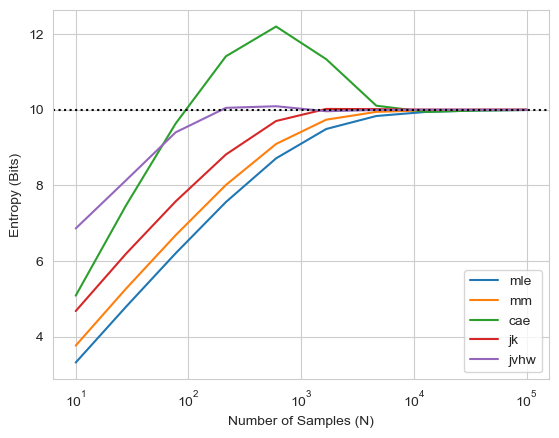

In [64]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle,  axis=1), label='mle')
plt.semilogx(sample_sizes, np.mean(h_mm,   axis=1), label='mm')
plt.semilogx(sample_sizes, np.mean(h_cae,  axis=1), label='cae')
plt.semilogx(sample_sizes, np.mean(h_jk,   axis=1), label='jk')
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label='jvhw')

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color='black', linestyle=':')

plt.xlabel("Number of Samples (N)")
plt.ylabel("Entropy (Bits)")

plt.legend()


### Zipf distribution

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (2 pts)

In [65]:
D = 10
N = 2**D

p = 1/(np.arange(0,N)+1)    # true distribution
p = p/np.sum(p)

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `random.choice` is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

True Entropy = 7.510649703297878
Entropy with 100 Samples = 5.785574336616448
Entropy with 10000 Samples = 7.449124507761412


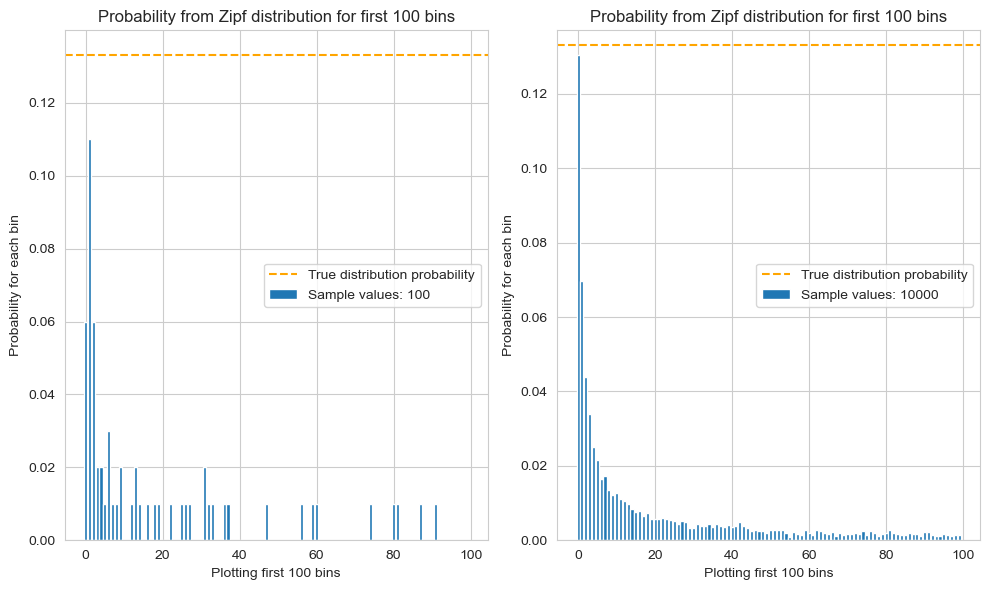

In [66]:
# insert your code here 

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 100 (0.5 pts)
# ---------------------------------------

S = 100
x1 = np.random.choice(N, size=int(S),p=p) # sample S values from 0 to N-1
p1 = np.bincount(x1, minlength=N) / S # estimate the distribution from the sample

H_100 = - np.sum(p1 * m_log(p1))

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 10000 (0.5 pts)
# ---------------------------------------

S = 10000
x2 = np.random.choice(N, size=int(S),p=p) # sample S values from 0 to N-1
p2 = np.bincount(x2, minlength=N) / S # estimate the distribution from the sample

H_10000 = - np.sum(p2 * m_log(p2))

print(f"True Entropy = {H}")
print(f"Entropy with 100 Samples = {H_100}")
print(f"Entropy with 10000 Samples = {H_10000}")

# ---------------------------------------
# Plot the true distribution and the sampled
# distributions. (0.5 pts)
# ---------------------------------------

fig, axis = plt.subplots(1,2,figsize=(10,6))

p_val = [p1,p2]
sample_val = [100, 10000]
for i in range(2):
    ax = axis[i]
    ax.bar(range(sample_val[i])[0:100], p_val[i][0:100], label=f'Sample values: {sample_val[i]}')
    ax.set_xlabel("Plotting first 100 bins")
    ax.set_ylabel("Probability for each bin")
    ax.axhline(p[0], label="True distribution probability",linestyle="--", color='Orange')
    ax.set_title("Probability from Zipf distribution for first 100 bins")
    ax.legend()
fig.tight_layout()



Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [67]:
sample_sizes = np.round(np.logspace(1,5,num=10))
n_runs = 30

edges = np.arange(-0.5, N, 1)

h_mle  = np.zeros((len(sample_sizes), n_runs))
h_mm   = np.zeros((len(sample_sizes), n_runs))
h_jk   = np.zeros((len(sample_sizes), n_runs))
h_cae  = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):
    
        # ---------------------------------------
        # Sample from the Zipf distribution
        # with different sample size (0.5 pts)
        # ---------------------------------------

        # insert your code here   
        
        x = np.random.choice(N, size=int(S),p=p) # sample S values from 0 to N-1
        phat = np.bincount(x, minlength=N) / S # estimate the distribution from the sample

        h_mle[i,j]  = entropy_mle(phat)
        h_mm[i,j]   = entropy_mm(phat, S)
        h_cae[i,j]  = entropy_cae(phat, S)
        h_jk[i,j]   = entropy_jk(x, edges)
        h_jvhw[i,j] = entropy_jvhw(x)


Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

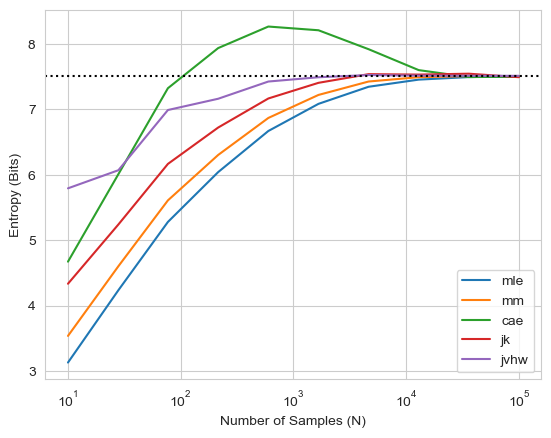

In [68]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle,  axis=1), label='mle')
plt.semilogx(sample_sizes, np.mean(h_mm,   axis=1), label='mm')
plt.semilogx(sample_sizes, np.mean(h_cae,  axis=1), label='cae')
plt.semilogx(sample_sizes, np.mean(h_jk,   axis=1), label='jk')
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label='jvhw')

# plot h_unseen or h_bub here if you implemented them.

plt.xlabel("Number of Samples (N)")
plt.ylabel("Entropy (Bits)")

plt.axhline(H, color='black', linestyle=':')
plt.legend()

